# FICO Score Bucketing Analysis

This notebook performs a detailed analysis of FICO scores from a loan dataset to identify optimal bucketing boundaries and calculate the corresponding probabilities of default. The approach leverages dynamic programming and Laplace smoothing to ensure robust results. Below is an overview of the key sections and functionalities in the notebook.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup and Imports

- **Drive Mounting:**  
  The notebook begins by mounting Google Drive (using `google.colab`) to access data files.

- **Library Imports:**  
  Essential libraries are imported:
  - **NumPy & Pandas:** For numerical operations and data manipulation.
  - **Matplotlib & Seaborn:** For creating various plots.
  - **Typing and Dataclasses:** To enforce type hints and structure data (using the `BucketResult` data class).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from dataclasses import dataclass

In [ ]:
@dataclass
class BucketResult:
    """Class to hold bucketing results"""
    boundaries: List[float]
    prob_default_values: List[float]  # Renamed from pd_values to avoid conflict with pandas
    log_likelihood: float
    bucket_ranges: List[Tuple[float, float]]

## 2. Data Loading and Preparation

- **Function:** `load_and_prepare_data(file_path)`  
  **Purpose:**  
  - Loads a CSV file containing the loan data.
  - Ensures that the dataset includes the required columns: `fico_score` and `default`.
  - Provides basic information about the dataset, such as its shape.

In [ ]:
def load_and_prepare_data(file_path: str) -> pd.DataFrame:
    """
    Load data and prepare it for FICO bucketing analysis

    Args:
        file_path: Path to the CSV file containing loan data

    Returns:
        DataFrame with 'fico_score' and 'default' columns
    """
    try:
        # Load the data file
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data from {file_path}")
        print(f"Data shape: {df.shape}")

        # Check if required columns exist
        required_cols = ['fico_score', 'default']
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in the dataset")

        # Extract and return the relevant columns
        return df[required_cols]
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

## 3. Bucketing Methodology

### 3.1. Data Structure for Results

- **Data Class:** `BucketResult`  
  **Contents:**  
  - `boundaries`: The optimal FICO score boundaries determined by the analysis.
  - `prob_default_values`: The calculated probability of default for each bucket.
  - `log_likelihood`: The total log-likelihood of the bucketing configuration.
  - `bucket_ranges`: The ranges corresponding to each bucket.

### 3.2. Core Functions

- **Function:** `compute_log_likelihood(j, i, cum_defaults, cum_counts, alpha)`  
  **Purpose:**  
  - Computes the log-likelihood for a segment of data between indices `j` and `i` using cumulative sums.
  - Applies Laplace smoothing (parameterized by `alpha`) to handle edge cases where probabilities might hit 0 or 1.

- **Function:** `optimal_bucketing(scores, defaults, n_buckets, alpha)`  
  **Purpose:**  
  - Implements a dynamic programming algorithm to partition the sorted FICO scores into an optimal set of buckets.
  - Uses cumulative sums of defaults and counts to efficiently compute the log-likelihood for different bucketing configurations.
  - Reconstructs the optimal bucket boundaries and calculates the corresponding probability of default for each bucket.

- **Function:** `calculate_pd_by_bucket(scores, defaults, boundaries)`  
  **Purpose:**  
  - Segments the data into buckets using the provided boundaries.
  - Computes the probability of default for each bucket with Laplace smoothing, ensuring stability in probability estimates.


In [ ]:
def compute_log_likelihood(j: int, i: int, cum_defaults: np.ndarray, cum_counts: np.ndarray, alpha: float = 1.0) -> float:
    """
    Compute log-likelihood for data points from j to i (exclusive) with Laplace smoothing.

    Args:
        j: Start index
        i: End index (exclusive)
        cum_defaults: Cumulative sum of defaults
        cum_counts: Cumulative count of samples
        alpha: Laplace smoothing parameter

    Returns:
        Log-likelihood value
    """
    ki = cum_defaults[i] - cum_defaults[j]
    ni = cum_counts[i] - cum_counts[j]

    if ni == 0:
        return -np.inf

    # Apply Laplace smoothing
    prob_i = (ki + alpha) / (ni + 2 * alpha)

    # Handle edge cases to avoid log(0)
    if prob_i <= 0:
        prob_i = alpha / (2 * alpha)
    elif prob_i >= 1:
        prob_i = (ni + alpha) / (ni + 2 * alpha)

    return ki * np.log(prob_i) + (ni - ki) * np.log(1 - prob_i)

In [ ]:
def optimal_bucketing(scores: np.ndarray, defaults: np.ndarray, n_buckets: int, alpha: float = 1.0) -> BucketResult:
    """
    Find optimal bucket boundaries for FICO scores using dynamic programming.

    Args:
        scores: Array of FICO scores, sorted in ascending order
        defaults: Array of default indicators (0 or 1)
        n_buckets: Number of buckets to create
        alpha: Laplace smoothing parameter

    Returns:
        BucketResult object containing the bucketing results
    """
    n = len(scores)

    # Compute cumulative sums for efficient calculation
    cum_defaults = np.cumsum(np.hstack([0, defaults]))
    cum_counts = np.cumsum(np.hstack([0, np.ones_like(defaults)]))

    # Initialize dynamic programming tables
    dp = -np.inf * np.ones((n_buckets + 1, n + 1))
    dp[0, 0] = 0
    back = np.zeros((n_buckets + 1, n + 1), dtype=int)

    # Dynamic programming to find optimal bucket boundaries
    for k in range(1, n_buckets + 1):
        for i in range(1, n + 1):
            for j in range(i):
                current_ll = dp[k-1, j] + compute_log_likelihood(j, i, cum_defaults, cum_counts, alpha)
                if current_ll > dp[k, i]:
                    dp[k, i] = current_ll
                    back[k, i] = j

    # Reconstruct the solution
    boundaries = []
    current = n
    for k in range(n_buckets, 0, -1):
        prev = back[k, current]
        # Use the actual FICO score as boundary
        boundaries.insert(0, scores[prev] if prev < len(scores) else scores[-1])
        current = prev

    # Remove duplicate boundaries and sort
    boundaries = sorted(list(set(boundaries)))

    # Define FICO score range constants
    min_fico = 300
    max_fico = 850

    # Create bucket ranges
    bucket_ranges = []
    prev = min_fico
    for boundary in boundaries:
        bucket_ranges.append((prev, boundary))
        prev = boundary
    bucket_ranges.append((prev, max_fico))

    # Calculate probability of default for each bucket
    prob_default_values = calculate_pd_by_bucket(scores, defaults, [min_fico] + boundaries + [max_fico])

    return BucketResult(
        boundaries=boundaries,
        prob_default_values=prob_default_values,
        log_likelihood=dp[n_buckets, n],
        bucket_ranges=bucket_ranges
    )

In [ ]:
def calculate_pd_by_bucket(scores: np.ndarray, defaults: np.ndarray, boundaries: List[float]) -> List[float]:
    """
    Calculate the probability of default for each bucket.

    Args:
        scores: Array of FICO scores
        defaults: Array of default indicators (0 or 1)
        boundaries: List of bucket boundaries including min and max FICO scores

    Returns:
        List of probability of default values for each bucket
    """
    df = pd.DataFrame({'fico_score': scores, 'default': defaults})

    # Assign each observation to a bucket
    df['bucket'] = pd.cut(df['fico_score'], bins=boundaries, labels=False, include_lowest=True)

    # Calculate probability of default with Laplace smoothing
    pd_df = df.groupby('bucket').agg(
        total=('default', 'count'),
        defaults=('default', 'sum')
    ).reset_index()

    # Apply Laplace smoothing: (count + 1) / (total + 2)
    pd_df['prob_default'] = pd_df.apply(
        lambda row: (row['defaults'] + 1) / (row['total'] + 2) if row['total'] > 0 else 0,
        axis=1
    )

    return pd_df['prob_default'].tolist()

## 4. Visualization

- **Function:** `visualize_bucketing_results(df, result, min_fico, max_fico)`  
  **Purpose:**  
  Generates three key visualizations:
  1. **FICO Score Distribution:**  
     A histogram of FICO scores with vertical red dashed lines marking the optimal bucket boundaries.
  2. **Probability of Default per Bucket:**  
     A bar plot displaying the default probability within each FICO bucket.
  3. **Combined View:**  
     An overlay of the FICO score distribution and the probability of default curve, using dual y-axes for clear comparison.

- **Function:** `compare_bucket_counts(scores, defaults, max_buckets)`  
  **Purpose:**  
  - Evaluates the log-likelihood for various bucket counts (ranging from 2 up to a specified maximum).
  - Plots the log-likelihood values to help decide the most appropriate number of buckets for the analysis.


In [ ]:
def visualize_bucketing_results(df: pd.DataFrame, result: BucketResult, min_fico: int = 300, max_fico: int = 850):
    """
    Create visualizations for the bucketing results.

    Args:
        df: DataFrame with 'fico_score' and 'default' columns
        result: BucketResult object from optimal_bucketing
        min_fico: Minimum FICO score (default: 300)
        max_fico: Maximum FICO score (default: 850)
    """
    # Define all boundaries including min and max FICO
    all_boundaries = [min_fico] + result.boundaries + [max_fico]

    # Assign buckets to data points
    df['bucket'] = pd.cut(df['fico_score'], bins=all_boundaries, labels=False, include_lowest=True)

    # Calculate probability of default per bucket with Laplace smoothing
    pd_df = df.groupby('bucket').agg(
        total=('default', 'count'),
        defaults=('default', 'sum')
    ).reset_index()

    pd_df['prob_default'] = pd_df.apply(
        lambda row: (row['defaults'] + 1) / (row['total'] + 2) if row['total'] > 0 else 0,
        axis=1
    )

    # Add bucket range labels for better visualization
    pd_df['bucket_range'] = [f"{int(low)}-{int(high)}" for low, high in result.bucket_ranges]

    # Plot 1: Distribution of FICO Scores with Bucket Boundaries
    plt.figure(figsize=(12, 6))
    sns.histplot(df['fico_score'], bins=30, kde=True, color='skyblue')
    plt.title('FICO Score Distribution with Optimal Bucket Boundaries')
    plt.xlabel('FICO Score')
    plt.ylabel('Count')

    # Add vertical lines for bucket boundaries
    for boundary in result.boundaries:
        plt.axvline(boundary, color='red', linestyle='--', alpha=0.7)

    plt.savefig('fico_distribution_with_boundaries.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Probability of Default (PD) per Bucket
    plt.figure(figsize=(12, 6))
    sns.barplot(x='bucket_range', y='prob_default', data=pd_df, palette='viridis')
    plt.title('Probability of Default by FICO Bucket')
    plt.xlabel('FICO Score Range')
    plt.ylabel('Probability of Default')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add text labels for PD values
    for index, row in pd_df.iterrows():
        plt.text(index, row.prob_default + 0.01, f'{row.prob_default:.3f}', ha='center')

    plt.savefig('pd_by_bucket.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 3: Combined View (FICO Distribution + PD Curve)
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # FICO score distribution
    ax1.hist(df['fico_score'], bins=30, color='skyblue', alpha=0.7)
    ax1.set_xlabel('FICO Score')
    ax1.set_ylabel('Frequency', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')

    # PD curve on secondary y-axis
    ax2 = ax1.twinx()
    bucket_midpoints = [(low + high) / 2 for low, high in result.bucket_ranges]
    ax2.plot(bucket_midpoints, result.prob_default_values, 'o-', color='darkred', linewidth=2, markersize=8)
    ax2.set_ylabel('Probability of Default', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')
    ax2.grid(alpha=0.3)

    plt.title('FICO Distribution & Probability of Default Relationship')
    plt.savefig('fico_distribution_and_pd.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def compare_bucket_counts(scores: np.ndarray, defaults: np.ndarray, max_buckets: int = 10):
    """
    Compare the log-likelihood for different numbers of buckets.

    Args:
        scores: Array of FICO scores
        defaults: Array of default indicators (0 or 1)
        max_buckets: Maximum number of buckets to consider
    """
    bucket_counts = range(2, max_buckets + 1)
    log_likelihoods = []

    # Calculate log-likelihood for each number of buckets
    for n_buckets in bucket_counts:
        print(f"Computing optimal bucketing with {n_buckets} buckets...")
        result = optimal_bucketing(scores, defaults, n_buckets)
        log_likelihoods.append(result.log_likelihood)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(bucket_counts, log_likelihoods, 'o-', linewidth=2)
    plt.title('Log-Likelihood by Number of Buckets')
    plt.xlabel('Number of Buckets')
    plt.ylabel('Log-Likelihood')
    plt.grid(True, alpha=0.3)
    plt.xticks(bucket_counts)

    # Add text labels for log-likelihood values
    for x, y in zip(bucket_counts, log_likelihoods):
        plt.text(x, y + 0.01, f'{y:.2f}', ha='center')

    plt.savefig('log_likelihood_by_bucket_count.png', dpi=300, bbox_inches='tight')
    plt.show()


## 5. Main Execution Flow

- **Function:** `main()`  
  **Workflow:**
  - **Data Loading:**  
    Loads and verifies the dataset, ensuring it contains the necessary FICO score and default data.
  - **Sorting:**  
    The dataset is sorted by FICO scores to facilitate proper bucketing.
  - **Bucketing Analysis:**  
    The notebook runs the `optimal_bucketing` function (using 5 buckets as an example) to determine the best bucket boundaries and calculate the corresponding default probabilities.
  - **Output:**  
    The optimal bucket ranges and their default probabilities are printed.
  - **Visualization:**  
    Visual plots are generated to visualize the FICO score distribution, bucket boundaries, and the relationship between scores and default probabilities.
  - **Bucket Count Comparison:**  
    A further analysis compares the log-likelihoods for different bucket counts, assisting in model selection.


Starting FICO score analysis...
Successfully loaded data from /content/Task 3 and 4_Loan_Data.csv
Data shape: (10000, 8)
Dataset loaded: 10000 records
FICO score range: 408 to 850
Default rate: 18.51%

Finding optimal bucketing with 5 buckets...

Optimal Bucket Boundaries:
Bucket 1: 300 - 408
Bucket 2: 408 - 521
Bucket 3: 521 - 580
Bucket 4: 580 - 640
Bucket 5: 640 - 696
Bucket 6: 696 - 850

Probability of Default per Bucket:
Bucket 1: 0.333333
Bucket 2: 0.652997
Bucket 3: 0.380201
Bucket 4: 0.204651
Bucket 5: 0.105345
Bucket 6: 0.047016

Creating visualizations...


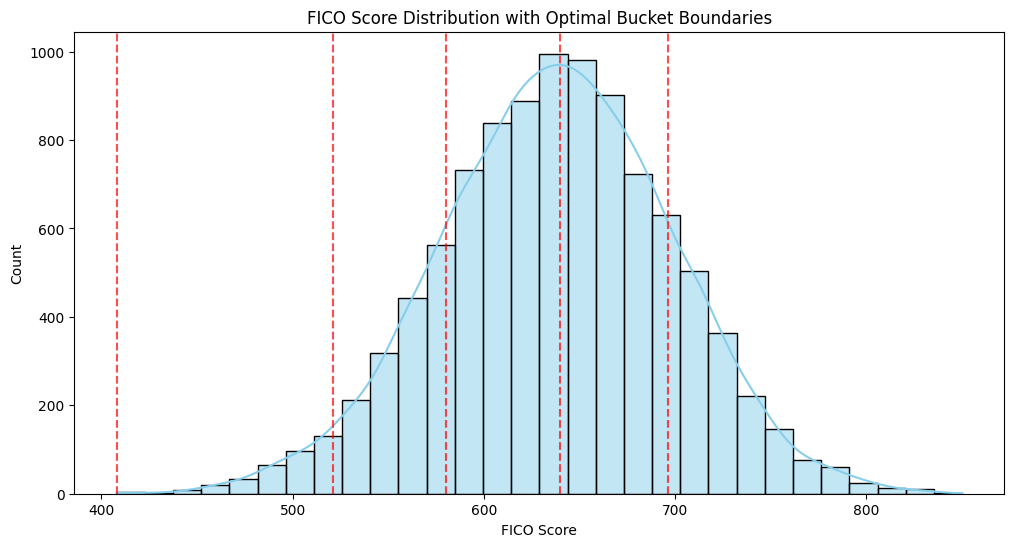

<ipython-input-9-c21c4ed8b43a>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bucket_range', y='prob_default', data=pd_df, palette='viridis')


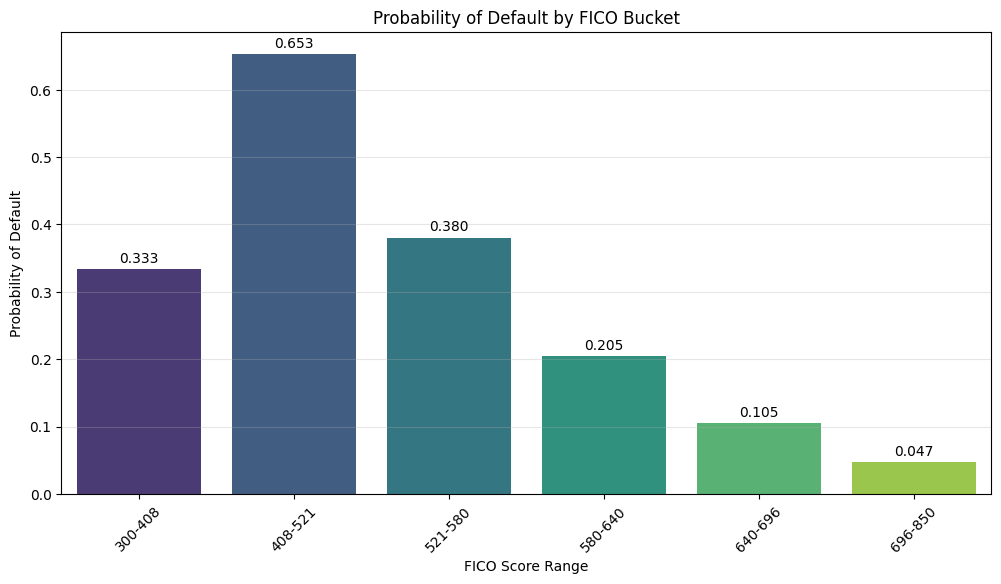

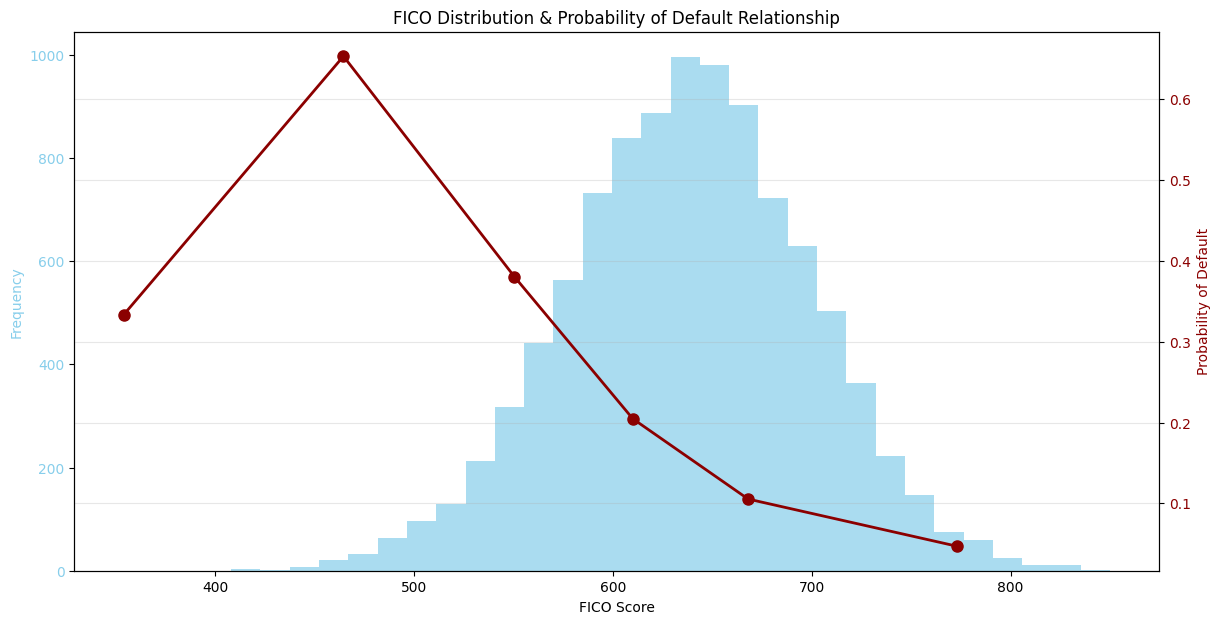


Comparing different numbers of buckets...
Computing optimal bucketing with 2 buckets...
Computing optimal bucketing with 3 buckets...
Computing optimal bucketing with 4 buckets...
Computing optimal bucketing with 5 buckets...
Computing optimal bucketing with 6 buckets...
Computing optimal bucketing with 7 buckets...
Computing optimal bucketing with 8 buckets...
Computing optimal bucketing with 9 buckets...
Computing optimal bucketing with 10 buckets...


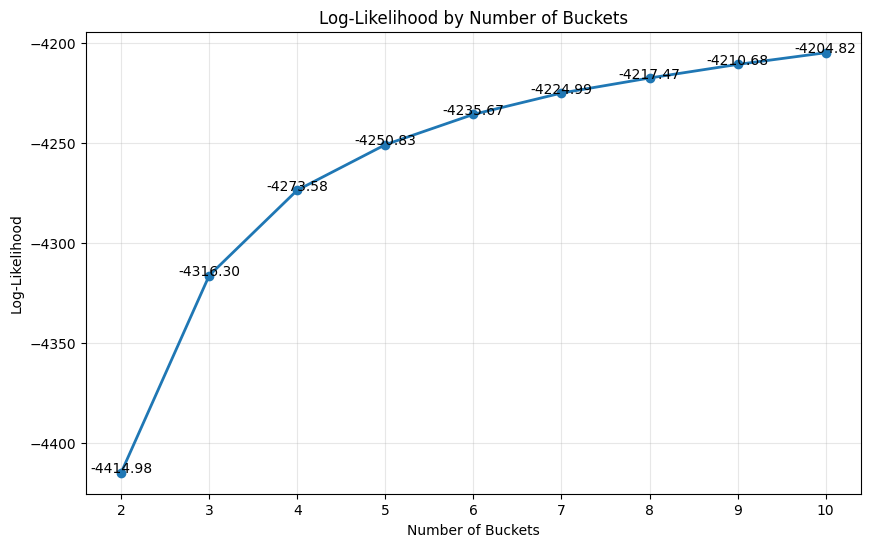


FICO score analysis completed.


In [ ]:
def main():
    """Main function to run the FICO analysis"""
    print("Starting FICO score analysis...")

    # Define file path - adjust as needed
    file_path = '/content/Task 3 and 4_Loan_Data.csv'

    # Load and prepare data
    try:
        df = load_and_prepare_data(file_path)
    except Exception as e:
        print(f"Error in data preparation: {e}")
        return

    # Check data quality
    if df.empty:
        print("Error: Dataset is empty")
        return

    print(f"Dataset loaded: {len(df)} records")
    print(f"FICO score range: {df['fico_score'].min()} to {df['fico_score'].max()}")
    print(f"Default rate: {df['default'].mean():.2%}")

    # Sort data by FICO score
    df_sorted = df.sort_values('fico_score').reset_index(drop=True)
    scores = df_sorted['fico_score'].values
    defaults = df_sorted['default'].values

    # Find optimal bucketing with 5 buckets
    n_buckets = 5
    print(f"\nFinding optimal bucketing with {n_buckets} buckets...")
    result = optimal_bucketing(scores, defaults, n_buckets)

    # Print results
    print("\nOptimal Bucket Boundaries:")
    for i, (low, high) in enumerate(result.bucket_ranges):
        print(f"Bucket {i+1}: {int(low)} - {int(high)}")

    print("\nProbability of Default per Bucket:")
    for i, prob_value in enumerate(result.prob_default_values):
        print(f"Bucket {i+1}: {prob_value:.6f}")

    # Visualize results
    print("\nCreating visualizations...")
    visualize_bucketing_results(df, result)

    # Compare different numbers of buckets
    print("\nComparing different numbers of buckets...")
    compare_bucket_counts(scores, defaults)

    print("\nFICO score analysis completed.")


if __name__ == "__main__":
    main()

## 6. Conclusion

This notebook provides a systematic approach to:
- **Analyze FICO scores** by segmenting them into statistically optimal buckets.
- **Estimate default probabilities** for each bucket with enhanced reliability through Laplace smoothing.
- **Visualize the results** to offer intuitive insights into the distribution of scores and the associated credit risk.
